In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#model processing
from sklearn.model_selection import train_test_split, KFold, cross_val_score, learning_curve, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

#models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

#evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, f1_score, log_loss, matthews_corrcoef

#model deployment
import pickle


In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [3]:
from google.colab import files
uploaded = files.upload()

Saving bank_ht.csv to bank_ht.csv


In [0]:
import io
bank = pd.read_csv(io.BytesIO(uploaded['bank_ht.csv']))

In [0]:
features = bank.drop('y', axis = 1)
target = bank['y'].apply(lambda x: 1 if x == 'yes' else 0)

In [0]:
## Splitting train and test set

X_train, X_test, y_train, y_test = train_test_split(features, target, 
                                                    test_size = 0.3, random_state = 101)

In [0]:
## Initiate the models
log_reg = LogisticRegression(solver = 'saga', max_iter = 1000, class_weight = 'balanced')
rfc = RandomForestClassifier(class_weight = 'balanced', max_depth = 6)
xgb = XGBClassifier(scale_pos_weight = 7.75)

## Hyperparameter Tuning for our models (logistic regression, RandomForestClassifier, and XGBClassifier)
Ideally, the tuning should be done using gridsearch. However, since I do not think my laptop is strong enough for this big dataset, I will use RandomizedSearchCV instead -- I increase the iteration into 15 times for each model. The best model will be used further.

In [0]:
# Hyperparameter Tuning
# Logistic Regression

max_iter = [1000, 1500, 2000, 3000]
penalty = ['l1', 'l2', 'elasticnet']
C = [0.01, 0.1, 1, 10,]

log_reg_param = {
                 'max_iter': max_iter,
                 'penalty': penalty,
                 'C': C}

In [0]:

log_random= RandomizedSearchCV(estimator = log_reg,
                              param_distributions = log_reg_param,
                              n_iter = 15, cv =5, n_jobs = -1, scoring = 'f1')

In [0]:
scaler = StandardScaler()

In [0]:
X_trainscale = scaler.fit_transform(X_train)
X_testscale = scaler.transform(X_test)

In [20]:
log_random.fit(X_trainscale, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=1000,
                                                multi_class='auto', n_jobs=None,
                                                penalty='l2', random_state=None,
                                                solver='saga', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='deprecated', n_iter=15, n_jobs=-1,
                   param_distributions={'C': [0.01, 0.1, 1, 10],
                                        'max_iter': [1000, 1500, 2000, 3000],
                                        'penalty': ['l1', 'l2', 'elasticnet']},
                   pre_dispatch='2*n_jobs', random_sta

In [21]:
log_random.best_params_

{'C': 10, 'max_iter': 3000, 'penalty': 'l1'}

In [22]:
log_random.best_score_

0.4276756477012569

In [0]:
#predicting the train set
log_pred_train = log_random.predict(X_trainscale)

In [24]:
f1_score(y_train, log_pred_train)

0.4279979413278435

In [25]:
print(classification_report(y_train, log_pred_train))

              precision    recall  f1-score   support

           0       0.95      0.83      0.88     25476
           1       0.32      0.63      0.43      3284

    accuracy                           0.81     28760
   macro avg       0.63      0.73      0.66     28760
weighted avg       0.87      0.81      0.83     28760



In [26]:
print(confusion_matrix(y_train, log_pred_train))

[[21124  4352]
 [ 1205  2079]]


In [0]:
# Now predicting the test set
log_pred_test = log_random.predict(X_testscale)

In [28]:
f1_score(y_test, log_pred_test)

0.422980431510286

In [29]:
print(confusion_matrix(y_test, log_pred_test))

[[9184 1803]
 [ 497  843]]


In [30]:
print(classification_report(y_test, log_pred_test))

              precision    recall  f1-score   support

           0       0.95      0.84      0.89     10987
           1       0.32      0.63      0.42      1340

    accuracy                           0.81     12327
   macro avg       0.63      0.73      0.66     12327
weighted avg       0.88      0.81      0.84     12327



The tuned logistic model yielded the exact same result as before tuning (the scores are exactly the same). We do not see any improvement from this process -- but this is probably caused by the process limitations in hyperparameter tuning (Randomized is faster, but probably can miss other better hyperparameter -- additionally, the options I put in the hyperparameter grid are probably not the best)

In [0]:
## Hyperparameter tuning for RFC

#number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 3000, num = 100)]

#number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']

#criterion
criterion = ['gini', 'entropy']

#maximum number of levels in trees
max_depth = [int(x) for x in np.linspace(10,110, num =20)]
max_depth.append(None)

#minimum number of samples required to split a node
min_samples_split = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 100)]

#minimum number of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.linspace(1,11,num = 10)]

#method of selecting samples for training each tree
bootstrap = [True, False]

#create the random grid
random_grid = {'n_estimators': n_estimators,
               'criterion': criterion,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap}

In [0]:
rf_random = RandomizedSearchCV(estimator = rfc,
                              param_distributions = random_grid,
                              n_iter = 15, cv =5, n_jobs = -1, scoring = 'f1')

In [36]:
rf_random

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight='balanced',
                                                    criterion='gini',
                                                    max_depth=6,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
            

In [37]:
rf_random.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight='balanced',
                                                    criterion='gini',
                                                    max_depth=6,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
            

In [38]:
rf_random.best_params_

{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': 57,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 209,
 'n_estimators': 2462}

In [39]:
rf_random.best_score_

0.479871677912268

In [0]:
# try to predict the train set

rf_train_ori = rf_random.predict(X_train)

In [41]:
f1_score(y_train, rf_train_ori)

0.49970797803994854

In [42]:
print(classification_report(y_train, rf_train_ori))

              precision    recall  f1-score   support

           0       0.95      0.88      0.91     25476
           1       0.41      0.65      0.50      3284

    accuracy                           0.85     28760
   macro avg       0.68      0.76      0.71     28760
weighted avg       0.89      0.85      0.87     28760



In [0]:
# Predicting the test set

rf_test_ori = rf_random.predict(X_test)

In [44]:
f1_score(y_test, rf_test_ori)

0.47305728871242203

In [45]:
print(confusion_matrix(y_test, rf_test_ori))

[[9635 1352]
 [ 506  834]]


In [46]:
print(classification_report(y_test, rf_test_ori))

              precision    recall  f1-score   support

           0       0.95      0.88      0.91     10987
           1       0.38      0.62      0.47      1340

    accuracy                           0.85     12327
   macro avg       0.67      0.75      0.69     12327
weighted avg       0.89      0.85      0.86     12327



Compared with the model without tuning, this tuned model is performing better -- although the number of True Positives is not increased (it is decreased 8 cases, which is a misclassification into False Negative, which is increased by 8 cases), but the number of false positives decreased by 149 cases. The number of True Negatives are also increasing 149 cases. Again, compared with logistic regression, RFC performed better in terms of the test scores.

In [0]:
# hyperparameter tuning for xgb first

param_learning = (0.05, 0.1, 0.3, 0.5, 0.8)
param_estimator = (100, 300, 500, 1000, 1500, 2000, 2500, 3000)
max_depth = (4, 6, 10, 15, 20)

xgbparam_grid = {'learning_rate': param_learning, 'n_estimators':param_estimator,
'max_depth' : max_depth}

In [0]:
xgb_random = RandomizedSearchCV(estimator = xgb,
                              param_distributions = xgbparam_grid,
                              n_iter = 15, cv =5, n_jobs = -1, scoring = 'f1')

In [49]:
#fitting into original dataset first
xgb_random.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=7.75,
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid=

In [51]:
xgb_random.best_score_

0.4435639413673882

In [52]:
xgb_random.best_params_

{'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 100}

In [0]:
# try to predict the train set

xgb_train_ori = xgb_random.predict(X_train)

In [54]:
f1_score(y_train, xgb_train_ori)

0.6205200281096275

In [55]:
print(classification_report(y_train, xgb_train_ori))

              precision    recall  f1-score   support

           0       0.97      0.90      0.93     25476
           1       0.50      0.81      0.62      3284

    accuracy                           0.89     28760
   macro avg       0.74      0.85      0.78     28760
weighted avg       0.92      0.89      0.90     28760



In [0]:
# Predicting the test set

xgb_test_ori = xgb_random.predict(X_test)

In [57]:
f1_score(y_test, xgb_test_ori)

0.43465827852444955

In [58]:
print(confusion_matrix(y_test, xgb_test_ori))

[[9590 1397]
 [ 580  760]]


In [59]:
print(classification_report(y_test, xgb_test_ori))

              precision    recall  f1-score   support

           0       0.94      0.87      0.91     10987
           1       0.35      0.57      0.43      1340

    accuracy                           0.84     12327
   macro avg       0.65      0.72      0.67     12327
weighted avg       0.88      0.84      0.86     12327



Here we see the same pattern as in logreg model -- there is no performance improvement for xgb after hyperparameter tuning. All the scores are the same as before tuning. 

Therefore, for now I will continue the modelling only using RFC model, with the tuned parameter.

In [0]:
rfc = RandomForestClassifier(bootstrap = True, criterion = 'entropy', max_depth =  57, max_features = 'log2', min_samples_leaf =  1,
                             min_samples_split =  209, n_estimators = 2462, class_weight = 'balanced')

In [61]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=57, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=209,
                       min_weight_fraction_leaf=0.0, n_estimators=2462,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

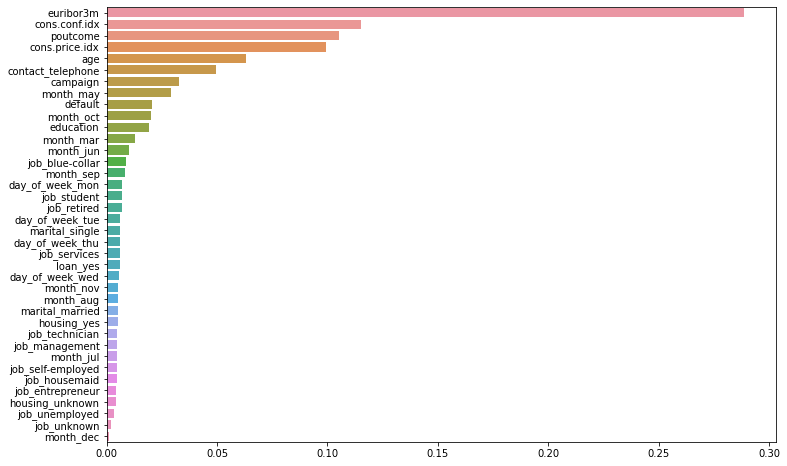

In [62]:
## let's see the feature importance
## Plotting based on the rfc default feature importance
plt.figure(figsize=(12,8))
importance=pd.Series(rfc.feature_importances_,index=X_train.columns).sort_values(ascending=False)

sns.barplot(x=importance,y=importance.index)


In RFC, the socio-economic features are considered really important (in the top 5), with the most important is the euribor3m. In this bar-plot, the information is telling us about which features are considered important in descending order --  however there is no information about how the features are influencing the target. Therefore I also use the sm Logit function (based from logistic regression) to see descriptively which features are significant in influencing the target and whether they are positive or negative influences to the target.

In [63]:
## descriptive features using sm logit
import statsmodels.api as sm

logit_model = sm.Logit(y_train, sm.add_constant(X_train))
result = logit_model.fit(method = 'bfgs', maxiter = 1000)
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.285803
         Iterations: 256
         Function evaluations: 261
         Gradient evaluations: 261
                           Results: Logit
Model:                Logit             Pseudo R-squared:  0.195     
Dependent Variable:   y                 AIC:               16517.3639
Date:                 2020-04-12 09:35  BIC:               16839.7668
No. Observations:     28760             Log-Likelihood:    -8219.7   
Df Model:             38                LL-Null:           -10215.   
Df Residuals:         28721             LLR p-value:       0.0000    
Converged:            1.0000            Scale:             1.0000    
---------------------------------------------------------------------
                   Coef.   Std.Err.    z     P>|z|   [0.025   0.975] 
---------------------------------------------------------------------
const             -47.6433   4.3608 -10.9255 0.0000 -56.1903 -39.0964
age          

Here we can see the features according to their significancies and their coefficient. This is the summary of significant features:

Positive coefficient:
default,
poutcome,
cons.price.idx,
cons.conf.idx,
job_student,
marital_married,
marital_single,
month_dec,
month_jul,
month_jun,
month_mar,
month_oct,
day_of_week_wed

negative coefficient:
campaign,
euribor3m,
job_blue-collar,
job_services,
contact_telephone,
month_may,
day_of_week_mon

Some of the significant features here are overlapped with the top important features based on RFC. 


In [0]:
#Here I tried to make a new dataframe including only significant features and top features (RFC)
# Let's train this new dataframe with our tuned RFC model

bank_sig = bank[['default', 'poutcome', 'cons.conf.idx', 'cons.price.idx', 'job_student', 'marital_married', 'marital_single', 'month_dec',
                 'month_jul', 'month_jun', 'month_mar', 'month_oct', 'day_of_week_wed', 'campaign', 'age', 'euribor3m','job_blue-collar',
                 'job_services', 'contact_telephone', 'month_may', 'day_of_week_mon', 'education']]

In [65]:
bank_sig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41087 entries, 0 to 41086
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   default            41087 non-null  int64  
 1   poutcome           41087 non-null  int64  
 2   cons.conf.idx      41087 non-null  float64
 3   cons.price.idx     41087 non-null  float64
 4   job_student        41087 non-null  int64  
 5   marital_married    41087 non-null  int64  
 6   marital_single     41087 non-null  int64  
 7   month_dec          41087 non-null  int64  
 8   month_jul          41087 non-null  int64  
 9   month_jun          41087 non-null  int64  
 10  month_mar          41087 non-null  int64  
 11  month_oct          41087 non-null  int64  
 12  day_of_week_wed    41087 non-null  int64  
 13  campaign           41087 non-null  int64  
 14  age                41087 non-null  int64  
 15  euribor3m          41087 non-null  float64
 16  job_blue-collar    410

In [0]:
## Splitting new dataset

Xtr, Xts, ytr, yts = train_test_split(bank_sig, target, 
                                                    test_size = 0.3, random_state = 101)

In [67]:
rfc.fit(Xtr,ytr)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=57, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=209,
                       min_weight_fraction_leaf=0.0, n_estimators=2462,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
rfc_train = rfc.predict(Xtr)

In [69]:
print(confusion_matrix(ytr,rfc_train))

[[22269  3207]
 [ 1146  2138]]


In [70]:
print(classification_report(ytr,rfc_train))

              precision    recall  f1-score   support

           0       0.95      0.87      0.91     25476
           1       0.40      0.65      0.50      3284

    accuracy                           0.85     28760
   macro avg       0.68      0.76      0.70     28760
weighted avg       0.89      0.85      0.86     28760



In [0]:
rfc_prediction = rfc.predict(Xts)

In [72]:
print(confusion_matrix(yts,rfc_prediction))

[[9617 1370]
 [ 502  838]]


In [73]:
print(classification_report(yts,rfc_prediction))

              precision    recall  f1-score   support

           0       0.95      0.88      0.91     10987
           1       0.38      0.63      0.47      1340

    accuracy                           0.85     12327
   macro avg       0.66      0.75      0.69     12327
weighted avg       0.89      0.85      0.86     12327



Turns out reducing the features did not really improve the performance of the model. It misclassifies about 18 cases of True Negative into False Positive, but also increase 4 cases of True Positives. 
Here I opt to use the original dataset.

## Model Stability

In [0]:
## KFold

# Making metrics functions first

def calc_train_error(X_train, y_train, model):
    predictions = model.predict(X_train)
    predictProba = model.predict_proba(X_train)
    matt = matthews_corrcoef(y_train, predictions)
    f1 = f1_score(y_train, predictions)
    report = classification_report(y_train, predictions)
    roc_auc = roc_auc_score(y_train, predictProba[:,1])
    accuracy = accuracy_score(y_train, predictions)
    confmatrix = confusion_matrix(y_train, predictions)
    logloss = log_loss(y_train, predictProba)
    return {
        'report': report,
        'matthew':matt,
        'f1': f1,
        'roc': roc_auc,
        'accuracy': accuracy,
        'confusion': confmatrix,
        'logloss': logloss
    }
  
def calc_validation_error(X_test, y_test, model):
    predictions = model.predict(X_test)
    predictProba = model.predict_proba(X_test)
    matt = matthews_corrcoef(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    report = classification_report(y_test, predictions)
    roc_auc = roc_auc_score(y_test, predictProba[:,1])
    accuracy = accuracy_score(y_test, predictions)
    confmatrix = confusion_matrix(y_test, predictions)
    logloss = log_loss(y_test, predictProba)
    return {
        'report': report,
        'matthew':matt,
        'f1': f1,
        'roc': roc_auc,
        'accuracy': accuracy,
        'confusion': confmatrix,
        'logloss': logloss
    }

def calc_metrics(X_train, y_train, X_test, y_test, model):
    model.fit(X_train, y_train)
    train_error = calc_train_error(X_train, y_train, model)
    validation_error = calc_validation_error(X_test, y_test, model)
    return train_error, validation_error

In [0]:
k = 5
kf = KFold(n_splits = k, shuffle = True, random_state = 101)

In [0]:
train_errors = []
valid_errors = []

for train_index, val_index in kf.split(features,target):
    
    #split data
    X_tr, X_val = features.iloc[train_index], features.iloc[val_index]
    y_tr, y_val = target.iloc[train_index], target.iloc[val_index]
    
    #instantiate model -- taking the one with the best hyperparameter according to the randomsearch
    rfc = RandomForestClassifier(bootstrap = True, criterion = 'entropy', max_depth =  57, max_features = 'log2', min_samples_leaf =  1,
                             min_samples_split =  209, n_estimators = 2462, class_weight = 'balanced')

    #calculate error
    train_error, valid_error = calc_metrics(X_tr, y_tr, X_val, y_val, rfc)
    
    #append to appropriate list
    train_errors.append(train_error)
    valid_errors.append(valid_error)

In [77]:
matrix  = []
for i, j in zip(train_errors, valid_errors):
    matrix.append([i['accuracy'], j['accuracy'], i['roc'], j['roc'], i['f1'], j['f1'], 
                   i['matthew'], j['matthew'], i['logloss'], j['logloss']])

calc_matrix = pd.DataFrame(matrix, columns = ['Train Accuracy', 'Test Accuracy', 'Train ROC AUC', 'Test ROC AUC',
                                             'Train F1 Score', 'Test F1 Score', 'Train Matthews Corr Coef', 
                                              'Test Matthews Corr Coef', 'Train Log Loss', 'Test Log Loss'])
average = []
for i in calc_matrix.columns:
    average.append(calc_matrix[i].mean())
    
average_mat = pd.DataFrame(average).T
average_mat.columns = ['Train Accuracy', 'Test Accuracy', 'Train ROC AUC', 'Test ROC AUC',
                                             'Train F1 Score', 'Test F1 Score', 'Train Matthews Corr Coef', 
                                              'Test Matthews Corr Coef', 'Train Log Loss', 'Test Log Loss']
index_label = []
for i in range(1, len(calc_matrix)+1):
    index_label.append(f'{i} Iteration')
index_label.append('Average')
calculation = pd.concat([calc_matrix, average_mat])
calculation.index = index_label
calculation

,Train Accuracy,Test Accuracy,Train ROC AUC,Test ROC AUC,Train F1 Score,Test F1 Score,Train Matthews Corr Coef,Test Matthews Corr Coef,Train Log Loss,Test Log Loss
1 Iteration,0.851075,0.848017,0.858818,0.809156,0.495725,0.479800,0.429612,0.416307,0.465177,0.477676
2 Iteration,0.852384,0.851910,0.862195,0.788155,0.501950,0.456454,0.436184,0.389471,0.460541,0.475786
3 Iteration,0.851445,0.846538,0.862920,0.800042,0.492886,0.491737,0.428628,0.420966,0.462323,0.481569
4 Iteration,0.851628,0.846416,0.859258,0.805102,0.492877,0.487825,0.428140,0.417412,0.464504,0.476464
5 Iteration,0.853605,0.850189,0.860422,0.806313,0.495703,0.492371,0.430801,0.423370,0.463560,0.478569
Average,0.852027,0.848614,0.860723,0.801753,0.495828,0.481637,0.430673,0.413505,0.463221,0.478013


Cross validation scores: [0.45443787 0.48946136 0.46992054 0.50352941 0.48974668 0.46064815
 0.48831776 0.48331415 0.49509804 0.48009101]


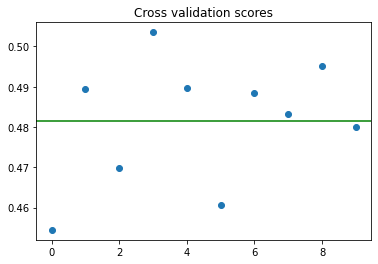

In [78]:
# from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator=rfc,
                        X=X_train,
                        y=y_train,
                        cv=10, 
                        n_jobs=1,
                        scoring = 'f1')

print('Cross validation scores: {}'.format(scores))

plt.title('Cross validation scores')
plt.scatter(np.arange(len(scores)), scores)
plt.axhline(y=np.mean(scores), color='g') # Mean value of cross validation scores
plt.show()

### Final Predictions before Deployment

In [80]:
# fitting once again just to make sure
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=57, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=209,
                       min_weight_fraction_leaf=0.0, n_estimators=2462,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
train_pred = rfc.predict(X_train)

In [0]:
test_pred = rfc.predict(X_test)

In [0]:
whole_pred = rfc.predict(features)

In [0]:
## Classification report and confusion matrix

name = ['train', 'test', 'whole']
predictions = [train_pred, test_pred, whole_pred]
targets = [y_train, y_test, target]

In [85]:
for i,j,k in zip(name, predictions, targets):
  print('In the {} set'.format(i))
  print(classification_report(k,j))
  print(confusion_matrix(k,j))
  print(' ')

In the train set
              precision    recall  f1-score   support

           0       0.95      0.88      0.91     25476
           1       0.41      0.65      0.50      3284

    accuracy                           0.85     28760
   macro avg       0.68      0.76      0.71     28760
weighted avg       0.89      0.85      0.87     28760

[[22343  3133]
 [ 1148  2136]]
 
In the test set
              precision    recall  f1-score   support

           0       0.95      0.88      0.91     10987
           1       0.38      0.62      0.47      1340

    accuracy                           0.85     12327
   macro avg       0.67      0.75      0.69     12327
weighted avg       0.89      0.85      0.86     12327

[[9635 1352]
 [ 503  837]]
 
In the whole set
              precision    recall  f1-score   support

           0       0.95      0.88      0.91     36463
           1       0.40      0.64      0.49      4624

    accuracy                           0.85     41087
   macro avg    

In [0]:
import pickle
filename = 'rfc_bank_v3.sav';
pickle.dump(rfc, open(filename, 'wb'))

In [89]:
from google.colab import files
files.download('rfc_bank_v3.sav')

KeyboardInterrupt: ignored

In [90]:
features.head()

,age,education,default,campaign,poutcome,cons.price.idx,cons.conf.idx,euribor3m,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,housing_unknown,housing_yes,loan_yes,contact_telephone,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed
0,56,0,1,1,0,93.994,-36.4,4.857,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0
1,57,3,0,1,0,93.994,-36.4,4.857,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0
2,37,3,1,1,0,93.994,-36.4,4.857,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0
3,40,1,1,1,0,93.994,-36.4,4.857,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0
4,56,3,1,1,0,93.994,-36.4,4.857,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0


In [2]:
bank = pd.read_csv('bank_ht.csv')

In [3]:
bank.head()

,age,education,default,campaign,poutcome,cons.price.idx,cons.conf.idx,euribor3m,job_blue-collar,job_entrepreneur,...,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,y
0,56,0,1,1,0,93.994,-36.4,4.857,0,0,...,0,1,0,0,0,1,0,0,0,no
1,57,3,0,1,0,93.994,-36.4,4.857,0,0,...,0,1,0,0,0,1,0,0,0,no
2,37,3,1,1,0,93.994,-36.4,4.857,0,0,...,0,1,0,0,0,1,0,0,0,no
3,40,1,1,1,0,93.994,-36.4,4.857,0,0,...,0,1,0,0,0,1,0,0,0,no
4,56,3,1,1,0,93.994,-36.4,4.857,0,0,...,0,1,0,0,0,1,0,0,0,no


In [4]:
load_Modelrf = pickle.load(open('rfc_bank_v3.sav', 'rb'))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [5]:
predictions = load_Modelrf.predict(bank.drop('y', axis = 1))

In [6]:
predictions

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [7]:
len(predictions)

41087

### Making a list of prospective customer

In [8]:
idx = []

for i, j in enumerate(predictions):
    if j == 1:
        idx.append(i)

In [10]:
len(idx)

7458

In [11]:
len(bank[bank['y']== 'yes'])

4624

In [12]:
bank.loc[idx]

,age,education,default,campaign,poutcome,cons.price.idx,cons.conf.idx,euribor3m,job_blue-collar,job_entrepreneur,...,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,y
23946,44,3,1,1,0,93.798,-40.4,5.045,0,0,...,0,0,0,1,0,0,0,0,0,no
23947,42,3,1,1,0,93.798,-40.4,5.045,0,0,...,0,0,0,1,0,0,0,0,0,yes
23948,39,2,1,1,0,93.798,-40.4,5.045,1,0,...,0,0,0,1,0,0,0,0,0,yes
23949,56,4,1,1,0,93.798,-40.4,5.045,0,0,...,0,0,0,1,0,0,0,0,0,yes
23950,30,4,1,1,0,93.798,-40.4,5.045,0,1,...,0,0,0,1,0,0,0,0,0,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41082,73,3,1,1,0,94.767,-50.8,1.028,0,0,...,0,0,1,0,0,0,0,0,0,yes
41083,46,3,1,1,0,94.767,-50.8,1.028,1,0,...,0,0,1,0,0,0,0,0,0,no
41084,56,4,1,2,0,94.767,-50.8,1.028,0,0,...,0,0,1,0,0,0,0,0,0,no
41085,44,3,1,1,0,94.767,-50.8,1.028,0,0,...,0,0,1,0,0,0,0,0,0,yes


In [13]:
prospective = pd.read_csv('bank_dash.csv')

In [14]:
prospective.head()

,Age,Job,Marital Status,Education,Default,Housing Loan,Personal Loan,Contact Type,Month,Day of Week,...,Calls in this Campaign,Days passed after previous campaign,Calls in previous Campaign,Previous Campaign Outcome,Employment Variation Rate,Consumer Price Index,Consumer Confidence Index,Euribor 3M,Number of people employed,y
0,56,Housemaid,Married,Basic 4y,No,No,No,Telephone,May,Mon,...,1,999,0,Nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,Services,Married,High school,Unknown,No,No,Telephone,May,Mon,...,1,999,0,Nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,Services,Married,High school,No,Yes,No,Telephone,May,Mon,...,1,999,0,Nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,Admin.,Married,Basic 6y,No,No,No,Telephone,May,Mon,...,1,999,0,Nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,Services,Married,High school,No,No,Yes,Telephone,May,Mon,...,1,999,0,Nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [15]:
prospective.drop('y', axis = 1, inplace = True)

In [16]:
prospective = prospective.loc[idx]

In [17]:
prospective.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7458 entries, 23946 to 41086
Data columns (total 20 columns):
Age                                    7458 non-null int64
Job                                    7458 non-null object
Marital Status                         7458 non-null object
Education                              7458 non-null object
Default                                7458 non-null object
Housing Loan                           7458 non-null object
Personal Loan                          7458 non-null object
Contact Type                           7458 non-null object
Month                                  7458 non-null object
Day of Week                            7458 non-null object
Last Call Duration                     7458 non-null int64
Calls in this Campaign                 7458 non-null int64
Days passed after previous campaign    7458 non-null int64
Calls in previous Campaign             7458 non-null int64
Previous Campaign Outcome              7458 non-null 

In [18]:
prospective.to_csv('prospective_customer.csv', index = False)

In [19]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41087 entries, 0 to 41086
Data columns (total 39 columns):
age                  41087 non-null int64
education            41087 non-null int64
default              41087 non-null int64
campaign             41087 non-null int64
poutcome             41087 non-null int64
cons.price.idx       41087 non-null float64
cons.conf.idx        41087 non-null float64
euribor3m            41087 non-null float64
job_blue-collar      41087 non-null int64
job_entrepreneur     41087 non-null int64
job_housemaid        41087 non-null int64
job_management       41087 non-null int64
job_retired          41087 non-null int64
job_self-employed    41087 non-null int64
job_services         41087 non-null int64
job_student          41087 non-null int64
job_technician       41087 non-null int64
job_unemployed       41087 non-null int64
job_unknown          41087 non-null int64
marital_married      41087 non-null int64
marital_single       41087 non-null int64
hou

In [20]:
dat = np.array([
21, 0, 0, 0, 0, 91, -36, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,1, 0,1, 0, 0,0,1, 0, 0, 0, 0, 0, 0, 0, 0,1,0,0,0]).reshape(1,-1)

In [21]:
proba = load_Modelrf.predict_proba(dat)

In [22]:
proba

array([[0.45495402, 0.54504598]])